<a href="https://colab.research.google.com/github/claredavies/ArtificialIntelligience/blob/main/WeLoveComputationalIntelligence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [25]:
!pip install scikit-fuzzy
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
import collections
from collections import OrderedDict


[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: pip install --upgrade pip


# Solving 3.2

In [26]:
def yp_solver(x):
  res = 0.2 * np.sin(2*np.pi*x + np.pi/4) + 0.5
  return res

def membership_solver_with_k(x, j_val, k_val):
  b_k = 1/(k_val - 1)
  a_j_k = (j_val-1)/(k_val-1)
  res = max(1-np.abs(x-a_j_k)/b_k, 0)
  return res

def yxp_solver(xp_val, b_vals, k_val=5):
  # this is the numerator
  numerator = 0
  for i in range(k_val):
    cur = membership_solver_with_k(xp_val, i+1, k_val) * b_vals[i]
    numerator += cur
  # this is the denominator
  denominator = 0
  for i in range(k_val):
    cur = membership_solver_with_k(xp_val, i+1, k_val)
    denominator += cur
  res = numerator/denominator
  return res

def performance_index(x_arr, yps, b_vals, k_val=5):
  m = len(x_arr)
  res = 0
  for p in range(m):
    res += (np.power(yxp_solver(x_arr[p], b_vals, k_val) - yps[p], 2))/2
  return res

def weight_calc(xp_val, j, alpha=10, k_val=5):
  # this is the μ 
  membership_value = membership_solver_with_k(xp_val, j, k_val)
  # this is the weight for j
  res = np.power(membership_value, alpha)
  return res

def b_calc(xps, yps, j, alpha=10, k_val=5):
  m = len(xps)
  # this is the numerator
  numerator = 0
  for p in range(0, m):
    weight_p = weight_calc(xps[p], j, alpha, k_val)
    weight_p_multiply_yp = weight_p * yps[p]
    numerator += weight_p_multiply_yp
  # this is the denominator 
  denominator = 0
  for p in range(0, m):
    weight_p = weight_calc(xps[p], j, alpha, k_val)
    denominator += weight_p
  res = numerator/denominator
  return res

# Solving 4.2

In [27]:
def yp_solver(x1, x2):
  inside = (1 + np.power(x1, -2) + np.power(x2, -1.5))
  res = np.power(inside, 2)
  return np.round(res, 2)

def membership_solver_with_k(x, j_val, k_val):
  b_k = 1/(k_val - 1)
  a_j_k = (j_val-1)/(k_val-1)
  res = max(1-np.abs(x-a_j_k)/b_k, 0)
  return res

def yxp_solver(x1_val, x2_val, b_dict, k1_val=5, k2_val=5):
  # this is the numerator
  numerator = 0
  for j1 in range(k1_val):
    for j2 in range(k2_val):
      cur = membership_solver_with_k(x1_val, j1+1, k1_val) * membership_solver_with_k(x2_val, j2+1, k2_val) * b_dict[j1+1][j2+1]
      numerator += cur
  # this is the denominator
  denominator = 0
  for j1 in range(k1_val):
    for j2 in range(k2_val):
      cur = membership_solver_with_k(x1_val, j1+1, k1_val) * membership_solver_with_k(x2_val, j2+1, k2_val)
      denominator += cur
  res = numerator/denominator
  return res

def performance_index(x1, x2, yps, b_dict, k1_val=5, k2_val=5):
  m = len(x1)
  res = 0
  for p in range(m):
    res += (np.power(yxp_solver(x1[p], x2[p], b_dict, k1_val, k2_val) - yps[p], 2))/2
  return res

def weight_calc(xp1_val, xp2_val, j1, j2, alpha=5, k1_val=5, k2_val=5):
  # this is the μ 
  membership_value = membership_solver_with_k(xp1_val, j1, k1_val) * membership_solver_with_k(xp2_val, j2, k2_val)
  
  # this is the weight for j1 and j2
  res = np.power(membership_value, alpha)
  return res

# TODO: is this correct
def b_calc(x1s, x2s, yps, j1, j2, alpha=5, k1_val=5, k2_val=5):
  m = len(x1s)
  
  # this is the numerator
  numerator = 0
  for p in range(0, m):
    weight_p = weight_calc(x1s[p],x2s[p], j1, j2, alpha, k1_val, k2_val)
    weight_p_multiply_yp = weight_p * yps[p]
    numerator += weight_p_multiply_yp
  
  # this is the denominator 
  denominator = 0
  for p in range(0, m):
    weight_p = weight_calc(x1s[p], x2s[p], j1, j2, alpha, k1_val, k2_val)
    denominator += weight_p
  res = numerator/denominator
  return res

def normalize_data(data):
    return np.round((data - np.min(data)) / (np.max(data) - np.min(data)), 2)

In [28]:
def membership_solver_with_k(x, j_val, k_val):
  b_k = 1/(k_val - 1)
  a_j_k = (j_val-1)/(k_val-1)
  res = max(1-np.abs(x-a_j_k)/b_k, 0)
  return res

def get_label(class_key):
  label_dict = {1: "S", 2: "MS", 3: "M", 4: "ML", 5: "L"}
  label = label_dict[class_key]
  return label

def get_centroid(j_val, k_val):
  centroid = (j_val-1)/(k_val-1)
  return centroid

def membership_solver_max_with_k(x, k_val):
  res_arr = []
  for j_i in range(1, k_val+1):
    res = membership_solver_with_k(x, j_i, k_val)
    res_arr.append(res)
  max_value = max(res_arr)
  max_index = res_arr.index(max_value)
  max_class = get_label(max_index+1)
  max_centroid = get_centroid(max_index+1, k_val)
  return max_class, max_value, max_centroid

def membership_solver_second_max_with_k(x, k_val):
  res_arr = []
  for j_i in range(1, k_val+1):
    res = membership_solver_with_k(x, j_i, k_val)
    res_arr.append(res)
  second_max_value = sorted(list(res_arr))[-2]
  second_max_index = res_arr.index(second_max_value)
  second_max_class = get_label(second_max_index+1)
  second_max_centroid = get_centroid(second_max_index+1, k_val)
  return second_max_class, second_max_value, second_max_centroid

In [29]:
def yxp_solver(x1_val, x2_val, b_dict, k1_val=5, k2_val=5):
  # this is the numerator
  numerator = 0
  for j1 in range(k1_val):
    for j2 in range(k2_val):
      cur = membership_solver_with_k(x1_val, j1+1, k1_val) * membership_solver_with_k(x2_val, j2+1, k2_val) * b_dict[j1+1][j2+1]
      numerator += cur
  # this is the denominator
  denominator = 0
  for j1 in range(k1_val):
    for j2 in range(k2_val):
      cur = membership_solver_with_k(x1_val, j1+1, k1_val) * membership_solver_with_k(x2_val, j2+1, k2_val)
      denominator += cur
  res = numerator/denominator
  return res

def yxp_solver_with_centroid(b_dict, xp1, xp2, k1_val=5, k2_val=5, b_k_val=5):
  y = 0
  # numerator
  numerator = 0
  for j1 in range(k1_val):
    for j2 in range(k2_val):
      b_j1_j2_val = b_dict[j1+1][j2+1]
      label1, max_value, max_centroid = membership_solver_max_with_k(b_j1_j2_val, b_k_val)
      label2, max_second_value, second_max_centroid = membership_solver_second_max_with_k(b_j1_j2_val, b_k_val)
      membership_value = membership_solver_with_k(xp1, j1+1, k1_val) * membership_solver_with_k(xp2, j2+1, k2_val)
      numerator += membership_value * max_centroid * max_value + membership_value * second_max_centroid * max_second_value

  #denominator
  denominator = 0
  for j1 in range(k1_val):
    for j2 in range(k2_val):
      b_j1_j2_val = b_dict[j1+1][j2+1]
      _, max_value, _ = membership_solver_max_with_k(b_j1_j2_val, b_k_val)
      _, max_second_value, _ = membership_solver_second_max_with_k(b_j1_j2_val, b_k_val)
      membership_value = membership_solver_with_k(xp1, j1+1, k1_val) * membership_solver_with_k(xp2, j2+1, k2_val)
      denominator += membership_value * max_value + membership_value * max_second_value

  # print(numerator, denominator)
  y = numerator/denominator
  return y

def performance_index(x1, x2, yps, b_dict, k1_val=5, k2_val=5, b_k_val=5):
  m = len(x1)
  res = 0
  for p in range(m):
    cur_res = (np.power(yxp_solver_with_centroid(b_dict, x1[p], x2[p], k1_val, k2_val, b_k_val) - yps[p], 2))/2
    res += cur_res
  return res

In [30]:
def generate_b_table(x1, x2, yp_orig):
# b dictionary for {j1: {j2: value}}
  b_dict = {1: {}, 2: {}, 3: {}, 4: {}, 5: {}}
  for i in range(5):
    for j in range(5):
      res = b_calc(x1, x2, yp_orig, i+1, j+1)
      b_dict[i+1][j+1] = res
  return b_dict

In [31]:
def generate_main_dict(b_dict):
  main_dict = {1: {}, 2: {}, 3: {}, 4: {}, 5: {}}
  for i in range(5):
    for j in range(5):
      b_j1_j2_val = b_dict[i+1][j+1]
      max_class, max_value, _ = membership_solver_max_with_k(b_j1_j2_val, 5)
      main_dict[i+1][j+1] = max_class
  return main_dict

def generate_secondary_dict(b_dict):
  second_dict = {1: {}, 2: {}, 3: {}, 4: {}, 5: {}}
  for i in range(5):
    for j in range(5):
      b_j1_j2_val = b_dict[i+1][j+1]
      max_second_class, max_second_value, _ = membership_solver_second_max_with_k(b_j1_j2_val, 5)
      second_dict[i+1][j+1] = max_second_class
  return second_dict

# Generate Data

In [32]:
from random import seed
from random import randint
seed(1)

x1 = []
x2 = []
y = []

for _ in range(50):
	x1.append(randint(150, 8000))
for _ in range(50):
	x2.append(randint(0, 450))


In [33]:
#Input generation

# x1: distance(km)
# x2: number of days left
# y: price

# x1: rand dist. 150km - 8000km
# x2: rand dist. 0 to 450

x2_dumb = [] #just for the calculation

for i in range(50):
  if(x2[i]>180):
    x2_dumb.append(180)
  else:
    x2_dumb.append(x2[i])
  y.append( x1[i]/4 + (pow((180-x2_dumb[i]),2)/16))
y

[312.5,
 2925.25,
 1773.0,
 1961.0625,
 1601.5,
 166.5,
 559.75,
 278.75,
 1284.5625,
 1596.75,
 1198.25,
 1004.5,
 1660.75,
 814.75,
 1652.75,
 531.25,
 2014.5625,
 1036.5,
 95.5,
 1867.0,
 1749.0,
 1875.8125,
 1375.3125,
 1281.5,
 1598.5,
 1608.5,
 94.3125,
 2347.5625,
 949.5,
 589.0,
 1515.0,
 1679.5,
 506.0,
 1248.0,
 1973.25,
 246.75,
 1883.5,
 1118.0625,
 139.0625,
 159.5625,
 89.5,
 1367.75,
 1146.25,
 56.25,
 1960.75,
 1842.25,
 818.0,
 3103.8125,
 481.0,
 1097.75]

In [34]:
import pandas as pd
df = pd.DataFrame(x1, columns=['Distance(km)'])
df['#. days left'] = x2
df['Price($)'] = y
df

,Distance(km),#. days left,Price($)
0,1250,371,312.5000
1,4812,14,2925.2500
2,7092,270,1773.0000
3,6722,113,1961.0625
4,6406,391,1601.5000
5,666,224,166.5000
6,2239,253,559.7500
7,1115,283,278.7500
8,4208,119,1284.5625
9,6383,176,1596.7500


In [35]:
# Dataset load
display(df.keys())
x1 = df["Distance(km)"].to_numpy()
x2 = df["#. days left"].to_numpy()
yp = df["Price($)"].to_numpy()

# Data normalization
x1 = normalize_data(x1)
x2 = normalize_data(x2)
yp = normalize_data(yp)

Index(['Distance(km)', '#. days left', 'Price($)'], dtype='object')

# Linguistic Labels

In [36]:
def createLinguisticLabels(range_values, k):
  label_list = []
  centroid_list = []
  start_list = []
  end_list = []

  for x in range(1, (k+1), 1):
    slot = (np.max(range_values) - np.min(range_values))/(k-1)
    start_centroid = np.min(range_values)
    
    if x == 1:
      start = 0
      centroid = start_centroid
      end = start + slot

    elif x == k:
      centroid = np.max(range_values)
      end = centroid
      start = end - slot

    else:
      centroid = start_centroid + (x-1)*slot
      start = centroid - slot
      end = centroid + slot

    label_list.append(x)
    centroid_list.append(centroid)
    start_list.append(start)
    end_list.append(end)
  
  df = pd.DataFrame(list(zip(label_list, centroid_list, start_list, end_list)),
               columns =['label', 'centroid', 'start', 'end'])
  
  return df

In [37]:
# Generate universe variables
K_labels = 5

x1_range = np.arange(0, 1.25, 0.25)
x2_range = np.arange(0, 1.25, 0.25)
y_range  = np.arange(0, 1.25, 0.25)

print(x1_range)

[0.   0.25 0.5  0.75 1.  ]


In [38]:
x1_df = createLinguisticLabels(x1_range, K_labels)
x2_df = createLinguisticLabels(x2_range, K_labels)
y_df = createLinguisticLabels(y_range, K_labels)

In [39]:
print(x1_df)

   label  centroid  start   end
0      1      0.00   0.00  0.25
1      2      0.25   0.00  0.50
2      3      0.50   0.25  0.75
3      4      0.75   0.50  1.00
4      5      1.00   0.75  1.00


In [40]:
# Generate fuzzy membership functions
# start point, y point, end point
x1_s = fuzz.trimf(x1_range, [x1_df["start"][0], x1_df["centroid"][0], x1_df["end"][0]])
x1_ms = fuzz.trimf(x1_range, [x1_df["start"][1], x1_df["centroid"][1], x1_df["end"][1]])
x1_m = fuzz.trimf(x1_range, [x1_df["start"][2], x1_df["centroid"][2], x1_df["end"][2]])
x1_ml = fuzz.trimf(x1_range, [x1_df["start"][3], x1_df["centroid"][3], x1_df["end"][3]])
x1_l = fuzz.trimf(x1_range, [x1_df["start"][4], x1_df["centroid"][4], x1_df["end"][4]])

x2_s = fuzz.trimf(x2_range, [x2_df["start"][0], x2_df["centroid"][0], x2_df["end"][0]])
x2_ms = fuzz.trimf(x2_range, [x2_df["start"][1], x2_df["centroid"][1], x2_df["end"][1]])
x2_m = fuzz.trimf(x2_range, [x2_df["start"][2], x2_df["centroid"][2], x2_df["end"][2]])
x2_ml = fuzz.trimf(x2_range, [x2_df["start"][3], x2_df["centroid"][3], x2_df["end"][3]])
x2_l = fuzz.trimf(x2_range, [x2_df["start"][4], x2_df["centroid"][4], x2_df["end"][4]])

y_s = fuzz.trimf(x1_range, [x1_df["start"][0], x1_df["centroid"][0], x1_df["end"][0]])
y_ms =  fuzz.trimf(x1_range, [x1_df["start"][1], x1_df["centroid"][1], x1_df["end"][1]])
y_m = fuzz.trimf(x1_range, [x1_df["start"][2], x1_df["centroid"][2], x1_df["end"][2]])
y_ml = fuzz.trimf(x1_range, [x1_df["start"][3], x1_df["centroid"][3], x1_df["end"][3]])
y_l = fuzz.trimf(x1_range, [x1_df["start"][4], x1_df["centroid"][4], x1_df["end"][4]])

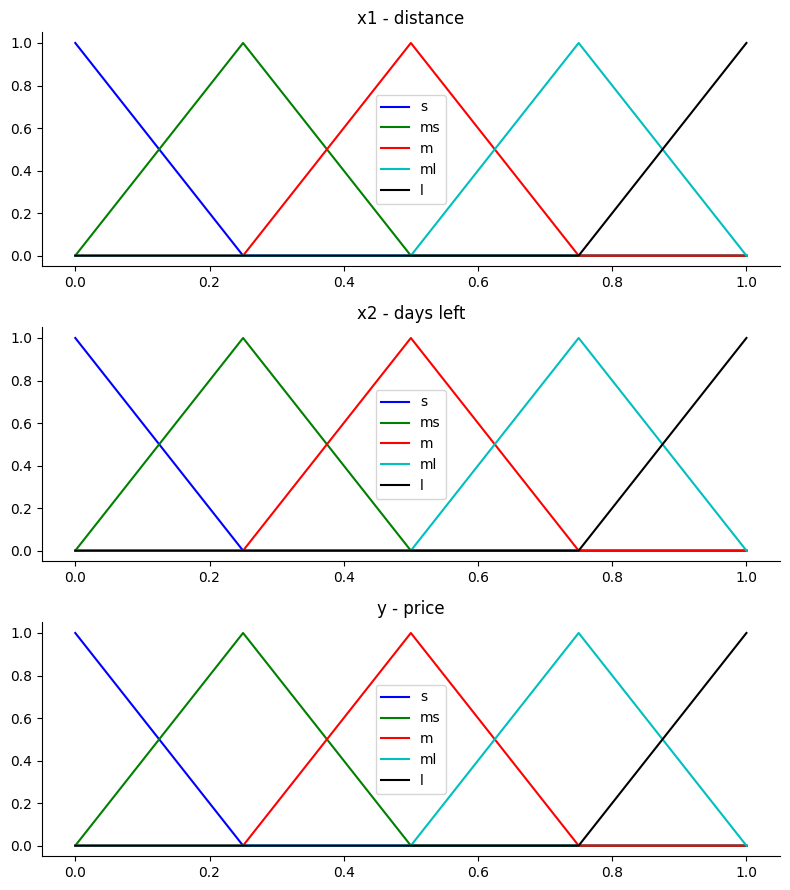

In [41]:
# Visualize these universes and membership functions
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(8, 9))

ax0.plot(x1_range, x1_s, 'b', linewidth=1.5, label='s')
ax0.plot(x1_range, x1_ms, 'g', linewidth=1.5, label='ms')
ax0.plot(x1_range, x1_m, 'r', linewidth=1.5, label='m')
ax0.plot(x1_range, x1_ml, 'c', linewidth=1.5, label='ml')
ax0.plot(x1_range, x1_l, 'k', linewidth=1.5, label='l')
ax0.set_title('x1 - distance')
ax0.legend()


ax1.plot(x2_range, x2_s, 'b', linewidth=1.5, label='s')
ax1.plot(x2_range, x2_ms, 'g', linewidth=1.5, label='ms')
ax1.plot(x2_range, x2_m, 'r', linewidth=1.5, label='m')
ax1.plot(x2_range, x2_ml, 'c', linewidth=1.5, label='ml')
ax1.plot(x2_range, x2_l, 'k', linewidth=1.5, label='l')
ax1.set_title('x2 - days left')
ax1.legend()

ax2.plot(y_range, y_s, 'b', linewidth=1.5, label='s')
ax2.plot(y_range, y_ms, 'g', linewidth=1.5, label='ms')
ax2.plot(y_range, y_m, 'r', linewidth=1.5, label='m')
ax2.plot(y_range, y_ml, 'c', linewidth=1.5, label='ml')
ax2.plot(y_range, y_l, 'k', linewidth=1.5, label='l')
ax2.set_title('y - price')
ax2.legend()

# Turn off top/right axes
for ax in (ax0, ax1, ax2):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

plt.tight_layout()

# Find b table, main table and secondary table for specific problem

Get b dictionary for data

In [42]:
b_dict = generate_b_table(x1, x2, yp)

print("{" + "\n".join("{!r}: {!r},".format(k, v) for k, v in b_dict.items()) + "}")

{1: {1: 0.64, 2: 0.022125026841160904, 3: 0.027140275570830596, 4: 0.011803750305135866, 5: 0.013841070104032734},
2: {1: 0.6363907955052416, 2: 0.21482354030784614, 3: 0.15237317771766593, 4: 0.10078518318665496, 5: 0.1642691524571328},
3: {1: 0.8868675893764586, 2: 0.3826829233729722, 3: 0.32474719456721096, 4: 0.3101468248225174, 5: 0.3209601523799926},
4: {1: 0.9856935968214833, 2: 0.5658993368986738, 3: 0.48175727221866055, 4: 0.48502294814388613, 5: 0.5090860881996035},
5: {1: 0.63, 2: 0.6291705226919106, 3: 0.6220092513442103, 4: 0.5939829177409353, 5: 0.5105200099561509},}


Get performance index

In [43]:
performance_index(x1, x2, yp, b_dict, 5, 5, 5)

0.007644384829792153

In [44]:
main_dict = generate_main_dict(b_dict)
second_dict = generate_secondary_dict(b_dict)

In [45]:
display(main_dict)

{1: {1: 'ML', 2: 'S', 3: 'S', 4: 'S', 5: 'S'},
 2: {1: 'ML', 2: 'MS', 3: 'MS', 4: 'S', 5: 'MS'},
 3: {1: 'L', 2: 'M', 3: 'MS', 4: 'MS', 5: 'MS'},
 4: {1: 'L', 2: 'M', 3: 'M', 4: 'M', 5: 'M'},
 5: {1: 'ML', 2: 'ML', 3: 'M', 4: 'M', 5: 'M'}}

In [46]:
display(second_dict)

{1: {1: 'M', 2: 'MS', 3: 'MS', 4: 'MS', 5: 'MS'},
 2: {1: 'M', 2: 'S', 3: 'S', 4: 'MS', 5: 'S'},
 3: {1: 'ML', 2: 'MS', 3: 'M', 4: 'M', 5: 'M'},
 4: {1: 'ML', 2: 'ML', 3: 'MS', 4: 'MS', 5: 'ML'},
 5: {1: 'M', 2: 'M', 3: 'ML', 4: 'ML', 5: 'ML'}}

# Results



In [51]:
upsampled = np.linspace(-2, 2, 21)
x_orig2 = [1, 2, 3, 4, 5]
y_orig2 = [1, 2, 3, 4, 5]
z_dict = {1: {1: 'ML', 2: 'S', 3: 'S', 4: 'S', 5: 'S'},
 2: {1: 'ML', 2: 'MS', 3: 'MS', 4: 'S', 5: 'MS'},
 3: {1: 'L', 2: 'M', 3: 'MS', 4: 'MS', 5: 'MS'},
 4: {1: 'L', 2: 'M', 3: 'M', 4: 'M', 5: 'M'},
 5: {1: 'ML', 2: 'ML', 3: 'M', 4: 'M', 5: 'M'}}
z_dict2 = {1: {1: 'M', 2: 'MS', 3: 'MS', 4: 'MS', 5: 'MS'},
 2: {1: 'M', 2: 'S', 3: 'S', 4: 'MS', 5: 'S'},
 3: {1: 'ML', 2: 'MS', 3: 'M', 4: 'M', 5: 'M'},
 4: {1: 'ML', 2: 'ML', 3: 'MS', 4: 'MS', 5: 'ML'},
 5: {1: 'M', 2: 'M', 3: 'ML', 4: 'ML', 5: 'ML'}}

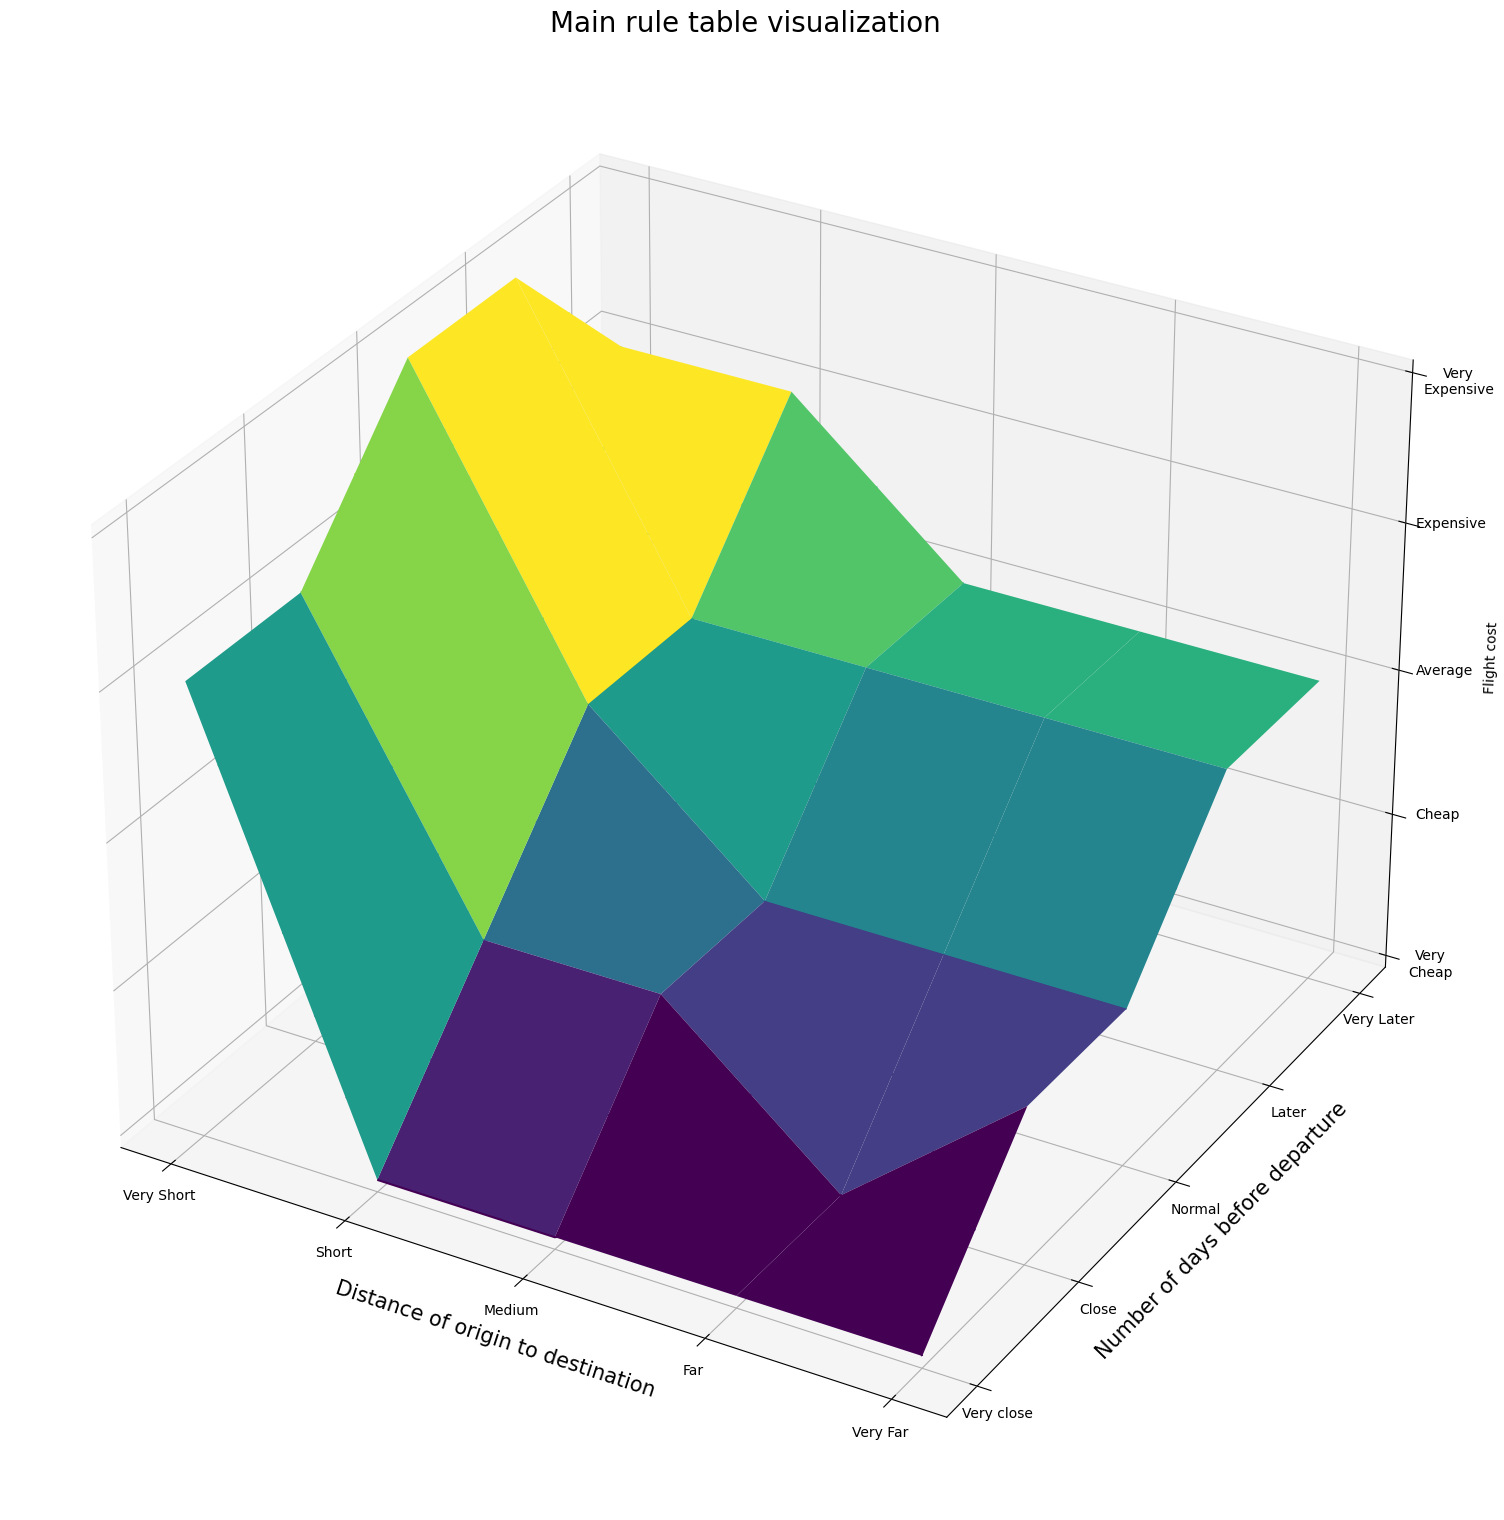

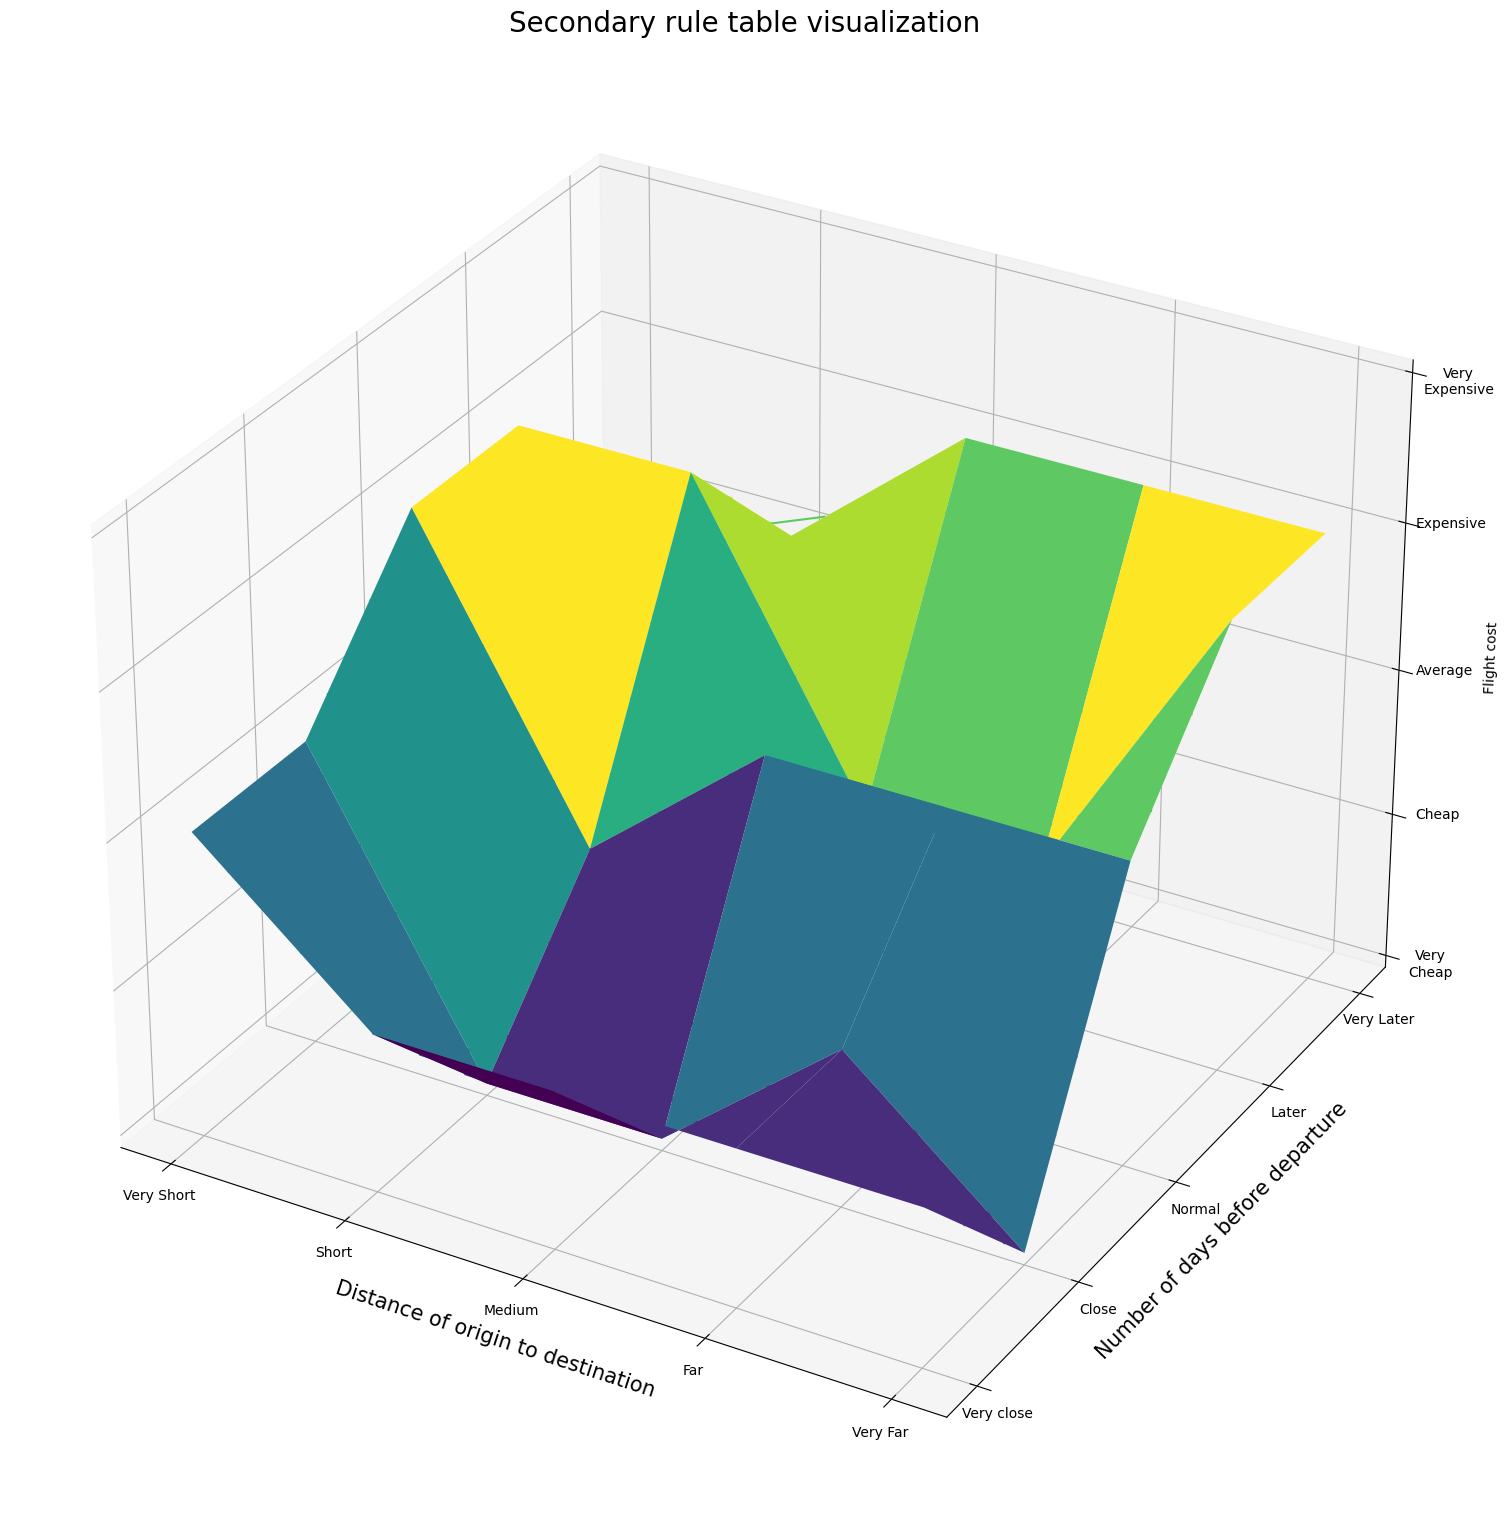

In [77]:
%matplotlib inline
def convert_label_to_int(label):
  res = 0
  if label =="L":
    res = 5
  if label == "ML":
    res = 4
  if label == "M":
    res = 3
  if label == "MS":
    res = 2
  if label == "S":
    res = 1
  return res

# We can simulate at higher resolution with full accuracy
def plot_table(x, y, z, title):
  # Plot the result in pretty 3D with alpha blending
  import matplotlib.pyplot as plt
  from mpl_toolkits.mplot3d import Axes3D # Required for 3D plotting

  fig = plt.figure(figsize=(15, 15))
  axes = fig.add_subplot(projection="3d")
  axes.plot_surface(x, y, z,cmap="viridis")
  plt.tight_layout()
  plt.xticks([1,2,3,4,5], ["Very Short", "Short", "Medium", "Far", "Very Far"])
  plt.yticks([1,2,3,4,5], ["Very close", "Close", "Normal", "Later", "Very Later"])
  plt.xlabel("Distance of origin to destination", fontsize=15)
  plt.ylabel("Number of days before departure", fontsize=15)
  plt.tick_params(axis='x', pad=5)
  plt.tick_params(axis='y', pad=5)
  axes.set_zlim3d(1, 5)
  axes.set_zticks([1,2,3,4,5])
  axes.set_zticklabels(["Very\nCheap", "Cheap", "Average", "Expensive", "Very\nExpensive"])
  axes.set_zlabel("Flight cost", fontsize=15)
  axes.tick_params(axis='z', pad=12)
  axes.zaxis.labelpad = 20
  axes.xaxis.labelpad = 10
  axes.yaxis.labelpad = 10
  plt.contour(x, y, z,cmap="viridis")
  plt.title(title, fontsize=20)
  plt.show()

x, y = np.meshgrid(x_orig2, y_orig2)
z_1= np.zeros_like(x)
z_2= np.zeros_like(x)
# Loop through the system 21*21 times to collect the control surface
for i in range(5):
  for j in range(5):
    res_1 = convert_label_to_int(z_dict[i+1][j+1])
    res_2 = convert_label_to_int(z_dict2[i+1][j+1])
    z_1[i,j] = res_1
    z_2[i,j] = res_2
plot_table(x, y, z_1, "Main rule table visualization")
plot_table(x, y, z_2, "Secondary rule table visualization")